In [3]:
from pyLIQTR.ProblemInstances.getInstance   import *
from pyLIQTR.BlockEncodings.getEncoding     import *
from pyLIQTR.utils.circuit_decomposition    import circuit_decompose_multi
from pyLIQTR.utils.resource_analysis        import estimate_resources
from pyLIQTR.qubitization.qubitized_gates   import QubitizedWalkOperator
from pyLIQTR.clam.lattice_definitions       import CubicLattice, SquareLattice, TriangularLattice
from pyLIQTR.utils.printing                 import openqasm
from pyLIQTR.scheduler.scheduler            import schedule_circuit
from pyLIQTR.scheduler.scheduler            import decomposition_protocol
import pyLIQTR.scheduler.sets as sets

import cirq
import qualtran as qt
import matplotlib.pyplot as plt


### Building circuit for scheduling

In [4]:
N=3

J_x = J_y = -0.5;                J_z = -1.0
h_x = 1.0;      h_y = 0.0;       h_z = 0.5

model  =  getInstance( "Heisenberg", 
                       shape=(N,N), 
                       J=(J_x,J_y,J_z), 
                       h=(h_x,h_y,h_z), 
                       cell=SquareLattice )

block_encoding    =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)
circuit = block_encoding.circuit

In [5]:
estimate_resources(circuit, circuit_precision=1e-3, profile=True)

c:\Users\RY32524\AppData\Local\anaconda3\envs\schedule\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


{'LogicalQubits': 15, 'T': 248, 'Clifford': 1194, 'Rotations': 128}

---
#### LIQTR Like 👍 : Circuit Scheduling
---

Circuits can be 'scheduled' using the `pyLIQTR.scheduler.scheduler.schedule_circuit` function. This will provide circuit runtime, realistic qubit counts, T-depth, and more!

(NOTE: If any operator's decomposition method returns `None` or `NotImplemented`, the scheduler will refer to the operator's `t_complexity` method for gate counts and execution time, but will not be able to fully parallelize the operator. If the operator does not have a decomposition method or a `t_complexity` method defined, the operator will be skipped each time it occurs in the circuit. In this event, scheduling results will not be accurate to the true circuit.)

`schedule_circuit` takes a number of optional arguments depending on desired outputs. They are:
* `architecture_config`: default `None`. A dictionary specifying timing for various gate types and restrictions on how many T gates can operate simultaneously. See 'Setting Gate Times and T-Gate Restriction' below for more info.

* `full_profile`: default `False`. If set to `True`, function output will include individual gate counts, T-widths, and parallelism distribution data. (NOTE: T-widths and parallelism data will only be available if `decomp_level` is set to `'Full'`.)

* `decomp_level`: default `0`. Levels of decomposition implemented before scheduling. If set to `0`, each operator will be decomposed to one/two-qubit gates only on its first occurance and cached for each future occurance. If set to `'Full'`, entire circuit will be decomposed to one/two-qubit gates before scheduling. 

    * NOTE: T-depth, qubit counts, and execution time will differ at different decomposition levels. In general, lower decomposition levels will trade circuit parallelism and low execution time for less qubit usage, whereas higher levels or full decomposition will maximize parallelism and decrease execution time while using more qubits. 

* `context`: default `None`. Defines qubit management context. We recommend not changing default settings unless required.

* `custom_gateset`: default `None`. A list specifying which gates to include in analysis. See 'Gateset Formatting' below for more info.

* `rotation_gate_precision`: default `1e-3`. Desired precision for circuit decomposition, namely breaking rotations into T-Gates.

* `decomposition_protocol`: default `decomposition_protocol.recursive`. Method of advanced decomposition to be used for complex operations, either `decomposition_protocol.recursive` or `decomposition_protocol.hierarchical`. See `advanced_decomposition_examples.ipynb` for further details.

* `qasm_output`: default `False`. If set to `True`, in addition to scheduling results, scheduler will print a qasm output of the scheduled circuit, including lines specifying start times of operations preceded by `#`.

* `display_op_cache`: default `False`. If set to `True`, in addition to scheduling results, scheduler will print each operator in its top-level cache along with that operator's stored results and how many times it occurred.

    * NOTE: Which operators appear in the cache will vary with different decomposition levels.

If `decomp_level == 'Full'`, the full results profile will include `Active Qubit Distribution` and `T-widths`. The first catologues how many qubits are active at each time-step in the scheduled circuit, while the second catologues the number of T-gates in each time-step. These results can be plotted as below for parallelism analysis:

In [6]:
res = schedule_circuit(circuit, full_profile=True, decomp_level='Full')
for r in res:
    print(f"{r} : {res[r]}")

Decomposition levels to basic gates: 5.
Total time for execution : 1351
Circuit T-depth : 124
Number of qubits used : 20
Gate profile : {'T': 248, 'H': 186, 'S': 104, 'CX': 666, 'CZ': 86, 'Pauli (X, Y, Z)': 354, 'Rotation': 126, 'Toffoli': 0}
Active qubit distribution : {15: 1, 5: 95, 6: 16, 1: 398, 3: 152, 4: 167, 2: 261, 9: 1, 7: 1}
T-widths : {0: 969, 5: 1, 1: 61, 2: 4, 3: 58}


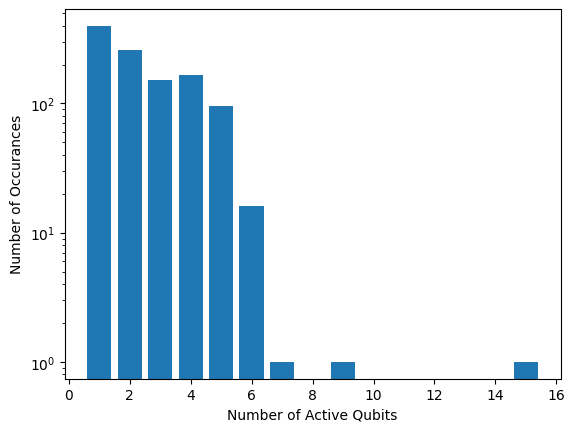

In [7]:
import matplotlib.pyplot as plt
aq = []
vals = []
for active_qubits in res['Active qubit distribution']:
        val = res['Active qubit distribution'][active_qubits]
        aq.append(active_qubits)
        vals.append(val)


fig, ax = plt.subplots()
ax.bar(aq, vals)
ax.set_ylabel("Number of Occurances")
ax.set_xlabel("Number of Active Qubits")
ax.set_yscale('log')


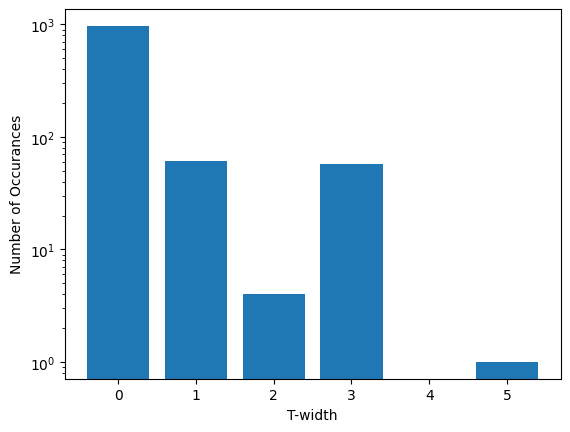

In [8]:
import matplotlib.pyplot as plt
tw = []
vals = []
for width in res['T-widths']:
        val = res['T-widths'][width]
        tw.append(width)
        vals.append(val)


fig, ax = plt.subplots()
ax.bar(tw, vals)
ax.set_ylabel("Number of Occurances")
ax.set_xlabel("T-width")
ax.set_yscale('log')

If `decomp_level != 'Full'`, these results will not be included (for now). However, a full gate profile will still be returned. You can also choose to print all cached operators, their cached results, and the number of times they each occurred by setting `return_op_cache = True`. Cache will vary with decomposition level.

In [9]:
res = schedule_circuit(circuit, full_profile=True, decomp_level=0, display_op_cache=True)
for r in res:
    print(f'{r}: {res[r]}')

PauliStringLCU occurred 1 times and had the following cached results: Execution time: 2268, T-depth: 248, Gates: {'T': 248, 'H': 186, 'S': 104, 'CX': 666, 'CZ': 86, 'Pauli (X, Y, Z)': 354, 'Rotation': 126}, Qubits: 20.
prepare_pauli_lcu occurred 1 times and had the following cached results: Execution time: 172, T-depth: 0, Gates: {'T': 0, 'H': 0, 'S': 0, 'CX': 62, 'CZ': 0, 'Pauli (X, Y, Z)': 0, 'Rotation': 63}, Qubits: 6.
<pyLIQTR.circuits.operators.prepare_oracle_pauli_lcu.QSP_Prepare object at 0x0000017A4C8D2BD0> occurred 1 times and had the following cached results: Execution time: 172, T-depth: 0, Gates: {'T': 0, 'H': 0, 'S': 0, 'CX': 62, 'CZ': 0, 'Pauli (X, Y, Z)': 0, 'Rotation': 63}, Qubits: 6.
SelectPauliLCU occurred 1 times and had the following cached results: Execution time: 1920, T-depth: 248, Gates: {'T': 248, 'H': 186, 'S': 104, 'CX': 542, 'CZ': 86, 'Pauli (X, Y, Z)': 354, 'Rotation': 0}, Qubits: 20.
And occurred 62 times and had the following cached results: Execution tim

#### Setting Gate Times and T-Gate Restriction:
To specify how long a particular gate takes to operate or how many T-Gates can operate simultaneously, the user can build a configuration dictionary to be passed to the `architecture_config` argument.

This dictionary must be formatted as follows:
    
`{'Execution Times': {('Gate 1',): Time X, ('Gate 2', 'Gate 3'): Time Y}, 'Max T': Z # of simultaneous T-gates allowed}`

In [10]:
resources = {'Execution Times': {
    ('T',): 5,
    ('CX',): 10,
    ('Rx', 'Ry'): 3}, 
'Max T': 1}

res = schedule_circuit(circuit, architecture_config=resources, full_profile=True, decomp_level=3)
for r in res:
    print(f"{r} : {res[r]}")

Total time for execution : 1748
Circuit T-depth : 180
Number of qubits used : 20
Gate profile : {'T': 248, 'H': 186, 'S': 104, 'CX': 666, 'CZ': 86, 'Pauli (X, Y, Z)': 354, 'Rotation': 126}


#### Gateset Formatting:

Custom gatesets can be used to decompose to, schedule, and count specific types of gates.

These sets MUST be formatted as follows:

`['first two characters of gate 1', 'first two characters of gate 2', ... 'Name of gateset']`

*Note that the name of the gateset must be the FINAL list entry.

Several of these sets can be compiled into a single list `[[], []]` to track multiple types of gatesets.

If a given gateset is found to be incomplete (i.e., a gate can be neither further decomposed nor classified into a given gateset), a `TypeError` will be raised and will inform the user which gate caused the error.

Alternatively, custom gatesets can be compiled from a list of pre-written sets, found in `pyLIQTR.scheduler.sets`. These sets, which can be directly imported and used, include:
* H
* S
* CX
* CZ
* Pauli (X, Y, Z)
* Clifford (includes all of the above gate types, but will return a total Clifford count)
* T
* Rotation
* Miscellaneous (this set should be included in ALL custom gatesets; it handles measurement and reset gates.)

Gates will be counted at the highest level specified OR in the order in which sets are listed. For example, if a user's custom gateset was:

* `mySet = [sets.T, sets.CLIFFORD, sets.MISC, ['An', 'And']]`, then `T` and `Clifford` gate counts would only include those gates whose origins were NOT an `And` gate.
* `mySet = [sets.CX, sets.CLIFFORD, sets.T, sets.MISC]`, then `Clifford` gate counts would include all types of Clifford gates EXCEPT `CX`, which would be counted separately.

Examples of this behavior are included below.

In [11]:
mygateset = [sets.T, sets.CLIFFORD, ['An', 'And'], sets.MISC]
res = schedule_circuit(circuit, full_profile=True, decomp_level='Full', custom_gateset=mygateset, decomposition_protocol=decomposition_protocol.recursive)
for r in res:
    print(f'{r}: {res[r]}')

Total time for execution: 13071
Circuit T-depth: 119
Number of qubits used: 20
Gate profile: {'T': 12978, 'Clifford': 26672, 'And': 124, 'Miscellaneous': 0}


In [12]:
mygateset = [sets.T, sets.CLIFFORD, sets.MISC]
res = schedule_circuit(circuit, full_profile=True, decomp_level=0, custom_gateset=mygateset, decomposition_protocol=decomposition_protocol.recursive)
for r in res:
    print(f'{r}: {res[r]}')

Total time for execution: 13939
Circuit T-depth: 305
Number of qubits used: 20
Gate profile: {'T': 13226, 'Clifford': 27478, 'Miscellaneous': 124}


In [13]:
mygateset = [sets.CX, sets.CLIFFORD, sets.T, sets.MISC]
res = schedule_circuit(circuit, full_profile=True, decomp_level=0, custom_gateset=mygateset, decomposition_protocol=decomposition_protocol.recursive)
for r in res:
    print(f'{r}: {res[r]}')

Total time for execution: 13939
Circuit T-depth: 305
Number of qubits used: 20
Gate profile: {'CX': 666, 'Clifford': 26812, 'T': 13226, 'Miscellaneous': 124}


### QASM input/output:

In addition to a `cirq.Circuit`, you can input a qasm string (or list of qasm strings) to the `circuit` argument of `schedule_circuit`. You can also receive the scheduled circuit as a qasm output. 

* NOTE: a number of features will not be available when using qasm input, including the ability to specify `custom_gateset` or any decomposition features. You CAN still use the `architecture_config` argument to specify gate timings and T-gate restrictions as above. 

In [14]:
circuit = ['h q[22]','h q[25]','h q[7]','t q[7]','cx q[18], q[7]','cx q[19], q[7]','cx q[7], q[18]','cx q[7], q[19]','tdg q[18]','tdg q[19]','t q[7]','cx q[7], q[18]', 'cx q[7], q[19]', 'h q[7]','s q[7]','h q[1]','t q[1]','cx q[7], q[1]','cx q[23], q[1]','cx q[1], q[7]', 'cx q[1], q[23]','tdg q[7]','tdg q[23]','t q[1]','cx q[1], q[7]','cx q[1], q[23]','h q[1]','s q[1]','h q[0]','t q[0]']

res = schedule_circuit(circuit, full_profile=True, qasm_output=True)
for r in res:
    print(f'{r}: {res[r]}')

#Operations finishing at 0: 
#Operations finishing at 1: 
h q[22]
h q[25]
h q[7]
h q[1]
h q[0]
#Operations finishing at 2: 
t q[7]
t q[1]
t q[0]
#Operations finishing at 4: 
cx q[19], q[7]
cx q[23], q[1]
#Operations finishing at 6: 
cx q[23], q[1]
cx q[7], q[19]
#Operations finishing at 7: 
tdg q[19]
#Operations finishing at 8: 
cx q[7], q[18]
#Operations finishing at 9: 
tdg q[18]
t q[7]
#Operations finishing at 11: 
cx q[7], q[19]
#Operations finishing at 13: 
cx q[7], q[18]
#Operations finishing at 14: 
h q[7]
#Operations finishing at 15: 
cx q[1], q[23]
s q[7]
#Operations finishing at 16: 
tdg q[7]
#Operations finishing at 17: 
cx q[1], q[23]
tdg q[7]
#Operations finishing at 19: 
cx q[1], q[7]
#Operations finishing at 20: 
t q[1]
#Operations finishing at 22: 
cx q[1], q[23]
#Operations finishing at 24: 
cx q[1], q[7]
#Operations finishing at 25: 
h q[1]
#Operations finishing at 26: 
s q[1]
Total time for execution: 26
Circuit T-depth: 6
Number of qubits used: 8
Gate profile: {'T':